In [2]:
import twitter, datetime
import json
import pymongo
from dotenv import load_dotenv 
import os 
import pandas
import preprocessor as p
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

load_dotenv()                  

mongo = os.environ.get('mongo')
db = os.environ.get('db')
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
hashtags = {'JohnsonAndJohnsonVaccine': ['JnJVaccine', 'JnJ', 'JohnsonAndJohnsonVaccine'],
            'PfizerVaccine': ['PfizerVaccine', 'Pfizer'],
            'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
            'Vaccinated': ['Vaccinated']
        }
# hashtags = {'ModernaVaccine': ['ModernaVaccine', 'Moderna'],
#             'Vaccinated': ['Vaccinated'] }

def oauth_login():
    '''
    A static method to authenticate user
    It uses OAuth2.0 specification which takes a bearer token to authenticate user
    '''

    CONSUMER_KEY = os.environ.get('CONSUMER_KEY')
    CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
    BEARER_TOKEN= os.environ.get('BEARER_TOKEN')
    
    auth = twitter.OAuth2(CONSUMER_KEY, CONSUMER_SECRET, BEARER_TOKEN)
    api = twitter.Twitter(auth=auth)
    return api

def clean_results(result, topic):
    '''
    To take required text for NLP, may change later as per the requirement
    '''
    final = []
    for arr in result["statuses"]:
        obj = dict()
        obj["tweet"] = arr["text"]
        obj["id"] = arr["id_str"]
        obj["name"] = arr["user"]["name"]
        obj["location"] = arr["user"]["location"]
        obj["topic"] = topic
        obj["created_at"] = arr["created_at"]
        obj["processed_on"] = datetime.datetime.now().isoformat(' ', 'seconds')
        final.append(obj)
    return final

def save_tweets_csv(tweets, topic):
    '''
    This method will help us on saving tweets
    '''
    try:
        fieldnames = list(tweets[0].keys())
        output_dir = os.path.join('data', 'csv')
        output_file = os.path.join(output_dir, topic+'.csv')
        if not os.path.exists(output_file):
            open(output_file, 'w').close()
        file_empty = os.stat(output_file).st_size == 0
        with open(output_file, mode='a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
            if file_empty:
                writer.writeheader() 
            writer.writerows(tweets)
        print("done inserting")
    except Exception as e:
        print(e)

def query_tweet(query, count, topic):
    '''
    Queries and finds tweet for different hashtags/topic, it will keep on searching until it finds total count
    '''
    api = oauth_login()
    meta = query.split("-RT")[0].split('#')[1]
    result = api.search.tweets(q=query, count=500)
    print(result["search_metadata"])
    save_tweets_csv(clean_results(result, meta), topic)
    result_count = result["search_metadata"]["count"]
    next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
    while result_count < count:
        result = api.search.tweets(q=query, include_entities='true',max_id=next_max_id, count=500 )
        print(result["search_metadata"])
        print(result_count)
        save_tweets_csv(clean_results(result, meta), topic)
        result_count += result["search_metadata"]["count"]
        if "next_results" in result["search_metadata"]:
            next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
        else:
            break
        
def get_docs_csv():   
    client = pymongo.MongoClient(mongo)
    database = client[db]
    for col in topics:
        coll = database[col] 
        try:
            result = coll.find()
            
            fieldnames = list(result[0].keys())
            fieldnames.remove('_id')

            output_dir = os.path.join('data', 'csv')
            output_file = os.path.join(output_dir, col+'.csv')
            with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction="ignore")
                writer.writeheader()
                writer.writerows(result)

        except Exception as e:
            print(e)

def remove_punctuations(text):
    punct =['%','/',':','\\','&amp;','&',';']
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

def get_value_counts(col_name, analyzer_name, tweets_df):
    '''
    This function returns count of the dataset passed, it uses pands library to do the same
    '''
    count = pandas.DataFrame(tweets_df[col_name].value_counts())
    percentage = pandas.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    counts = pandas.concat([count, percentage], axis = 1)
    counts = counts.reset_index()
    counts.columns = ['sentiment', 'counts', 'percentage']
    counts.sort_values('sentiment', inplace = True)
    counts['percentage'] = counts['percentage'].apply(lambda x: round(x,2))
    counts = counts.reset_index(drop = True)
    counts['analyzer'] = analyzer_name
    return counts

def fetch_tweets():
    '''
    This method fetches and stores the tweets for the last seven days and store it in the mongodb
    '''
    try:
        for key in hashtags.keys():
            for topic in hashtags[key]:
                query_tweet("#"+ topic+" -RT AND lang:en", 10000, key)
        print("Done fetching tweets")
    except Exception as e:
        print(e)

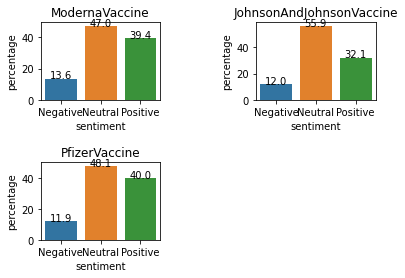

In [4]:
topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine", "Vaccinated"]
# topics = ["ModernaVaccine"]
final_bar = []
result_copy = dict()
for topic in topics:          
        file_dir = os.path.join('data', 'csv')
        file = os.path.join(file_dir, topic+'.csv')
        result = pandas.read_csv(file)
        result.sort_values(by="created_at")
        result_copy[topic] = result.copy()
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet'].apply(lambda x: p.clean(x))
        result_copy[topic].drop_duplicates(subset='tweet_cleaned', keep='first', inplace=True)

        # remove punctuations
        result_copy[topic]['tweet_cleaned'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: remove_punctuations(x))

        # Drop tweets which have empty text field
        result_copy[topic]['tweet_cleaned'].replace('', np.nan, inplace=True)
        result_copy[topic]['tweet_cleaned'].replace(' ', np.nan, inplace=True)
        result_copy[topic].dropna(subset=['tweet_cleaned'], inplace=True)

        result_copy[topic] = result_copy[topic].reset_index(drop=True)

        #sentiment analysis
        # Obtain polarity scores generated by TextBlob
        result_copy[topic]['textblob_score'] = result_copy[topic]['tweet_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
        # neutral_thresh = 0.05

        # Convert polarity score into sentiment categories
        result_copy[topic]['textblob_sentiment'] = result_copy[topic]['textblob_score'].apply(lambda c: 'Positive' if c >= 0.02 else ('Negative' if c <= -(0.02) else 'Neutral'))
        
        textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob', result_copy[topic])

        final_bar.append(textblob_sentiment_df)

# bargraph plotting
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)

# plt.rcParams["figure.figsize"] = (25,8)

ax = fig.add_subplot(2, 2, 1)
ax.set_title(topics[0])
for index, row in final_bar[0].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[0], ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set_title(topics[1])
for index, row in final_bar[1].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[1], ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set_title(topics[2])
for index, row in final_bar[2].iterrows():
        ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")
sns.barplot(x="sentiment", y="percentage", data=final_bar[2], ax=ax)

plt.show()



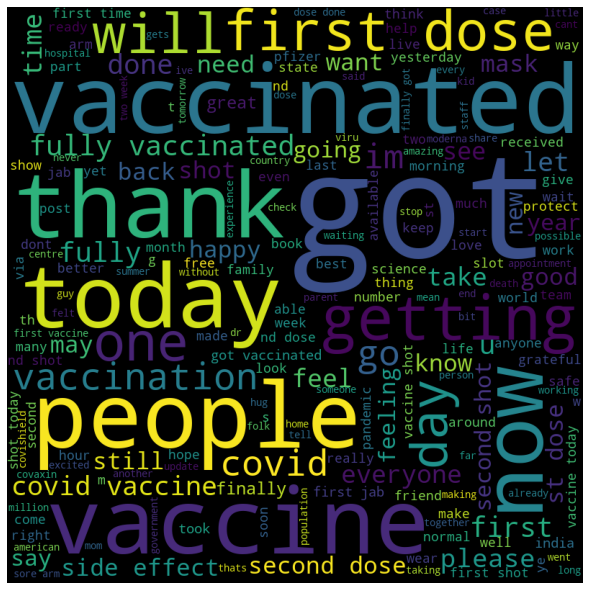

In [5]:
#worldcloud
#vaccinated
comment_words = ''
stopwords = set(STOPWORDS)
for val in result_copy['Vaccinated'].values:
    row = val[7]
    tokens = row.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

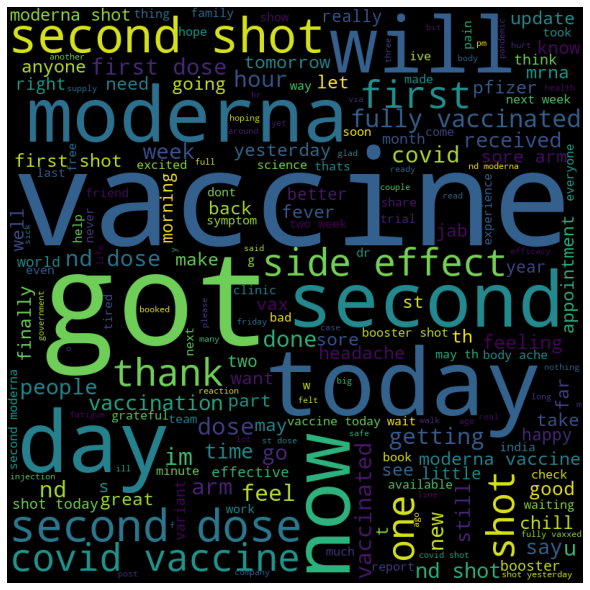

In [6]:
#worldcloud
#vaccinated
comment_words = ''
stopwords = set(STOPWORDS)
for val in result_copy['ModernaVaccine'].values:
    row = val[7]
    tokens = row.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

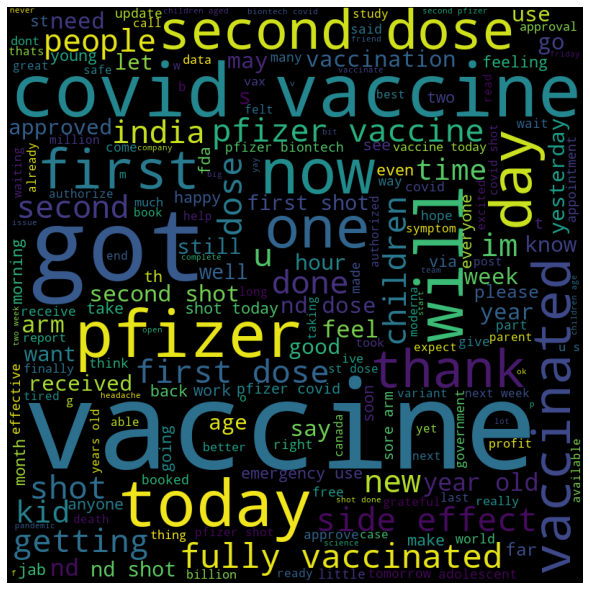

In [7]:
#worldcloud
#vaccinated
comment_words = ''
stopwords = set(STOPWORDS)
for val in result_copy['PfizerVaccine'].values:
    row = val[7]
    tokens = row.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

SyntaxError: invalid syntax (<ipython-input-23-1ca5879492b8>, line 1)

In [8]:
state_codes = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", 
          "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", 
          "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", 
          "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
        
states_mapping = { "Alabama": "AL", "Alaska": "AK", "Arizona" : "AZ", "Arkansas": "AR", "California": "CA", 
    "Colorado": "CO", "Connecticut": "CT", "Washington DC": "DC", "Delaware": "DE", "Florida": "FL", 
    "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", 
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", 
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", 
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", 
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", 
    "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", 
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", 
    "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",  
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY" }

for topic in topics:
        for index, row in result_copy[topic].iterrows():
            flag = 0
            if row.location:
                location_split = str(row.location).split(',')
                for word in location_split:
                    word = word.strip()
                    for state, code in states_mapping.items():
                        if state == word.title() or code == word:
                            result_copy[topic].loc[index, 'states'] = code
                            flag = 1
                            break
                    if flag == 1:
                        break
                # if flag == 0:
                #     result_copy[topic].loc[index, 'states'] = ''


In [9]:
result_copy['ModernaVaccine'].head(10)

,tweet,id,name,location,topic,created_at,processed_on,tweet_cleaned,textblob_score,textblob_sentiment,states
0,#SnowBae is knocked out by second dose of #mod...,1390079274930081793,"👩🏻‍⚕️Brenda the NP, PhD-to-be 🤓",NaN,ModernaVaccine,Wed May 05 23:01:40 +0000 2021,2021-05-05 19:14:04,is knocked out by second dose of - this is an ...,0.078571,Positive,NaN
1,Got my second Moderna Covid vaccine this after...,1390077220211802115,Lori 🇮🇪🇺🇲🇩🇪🍸👫👬👭,NaN,ModernaVaccine,Wed May 05 22:53:30 +0000 2021,2021-05-05 19:14:04,Got my second Moderna Covid vaccine this after...,0.050000,Positive,NaN
2,#ModernaVaccine appointments available for May...,1390076238308548609,Long Island Community Hospital,"Patchogue, NY",ModernaVaccine,Wed May 05 22:49:36 +0000 2021,2021-05-05 19:14:04,"appointments available for May th, th and th! ...",0.500000,Positive,NY
3,Apart from feeling awfully sick for three hour...,1390068100733747205,C O (he/him) (Moderna Gang),"UK, EU",ModernaVaccine,Wed May 05 22:17:16 +0000 2021,2021-05-05 19:14:04,Apart from feeling awfully sick for three hour...,-0.204762,Negative,NaN
4,Limited data from small test trial shows posit...,1390065208949833728,timethief (retired paralegal judicial assistant),"Salish Sea, B.C.",ModernaVaccine,Wed May 05 22:05:46 +0000 2021,2021-05-05 19:14:04,Limited data from small test trial shows posit...,-0.031385,Negative,NaN
5,If anyone wants to follow this whole bizzaro t...,1390061573847273472,✨Crystal ✨,"Kentucky, USA",ModernaVaccine,Wed May 05 21:51:19 +0000 2021,2021-05-05 19:14:04,If anyone wants to follow this whole bizzaro t...,0.200000,Positive,KY
6,I'd like to thank Her Royal Higness Queen Eliz...,1390061334180499459,Reverend Nate,"Alberta, Canada",ModernaVaccine,Wed May 05 21:50:22 +0000 2021,2021-05-05 19:14:04,I'd like to thank Her Royal Higness Queen Eliz...,0.400000,Positive,NaN
7,Finally got that first #modernavaccine dose. A...,1390060614656040960,Jake | SamuraiEVO,"Los Angeles, CA",ModernaVaccine,Wed May 05 21:47:31 +0000 2021,2021-05-05 19:14:04,Finally got that first dose. A bit surreal to ...,0.275000,Positive,CA
8,Moderna says Covid booster shot generates prom...,1390059689522601984,SPIRIT,宮城県 仙台市 太白区,ModernaVaccine,Wed May 05 21:43:50 +0000 2021,2021-05-05 19:14:04,Moderna says Covid booster shot generates prom...,0.200000,Positive,NaN
9,I have see a lot of people talk about the sid...,1390048052300460042,Moe 𓂀 🇪🇬,NaN,ModernaVaccine,Wed May 05 20:57:36 +0000 2021,2021-05-05 19:14:04,I have see a lot of people talk about the side...,0.000000,Neutral,NaN


In [10]:
#Scatterplot for pfizer
# x = [2,2,8,1,15,8,12,9,7,3,11,4,7,14,12]
# y = [100,105,84,105,90,99,90,95,94,100,79,112,91,80,85]
# plt.scatter(x, y)   

# plt.show()

In [11]:
# result_copy['ModernaVaccine']['states'].head(100)

In [12]:
result_states = {}
for topic in topics:
    result_states[topic] = result_copy[topic][result_copy[topic]['states'].notna()]

In [13]:
# result_states['PfizerVaccine'].head(10)

In [14]:
unique_states = result_states['PfizerVaccine']['states'].unique().tolist()

In [15]:
# plotly for all the vaccines
import plotly.express as px

plotly = []
arr_Pfizer = (result_copy['PfizerVaccine']['textblob_score'].head(550)).tolist()
arr_JnJ = (result_copy['JohnsonAndJohnsonVaccine']['textblob_score'].head(550)).tolist()
arr_Moderna = (result_copy['ModernaVaccine']['textblob_score'].head(550)).tolist()
# print(arr_Pfizer)
plotly.append(arr_Pfizer)
plotly.append(arr_JnJ)
plotly.append(arr_Moderna)
plotly = [[plotly[j][i] for j in range(len(plotly))] for i in range(len(plotly[0]))]

<AxesSubplot:>

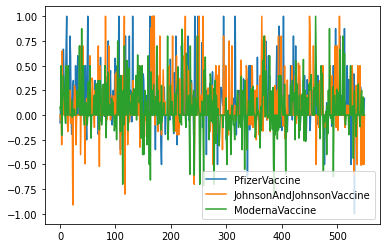

In [18]:
df_1 = pandas.DataFrame(plotly, columns=['Pfizer','JohnsonAndJohnson','Moderna'])

# Compare old plots to a Plotly interactive plot
# You can save as PNG, Zoom, Pan, Turn off & on Data and more
df_1.plot()
df_1.style
